In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import joblib
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
                                    StratifiedKFold,
                                    cross_validate,
                                    GridSearchCV,
                                    RandomizedSearchCV
                                )
from sklearn.metrics import (
                            classification_report,
                            confusion_matrix,
                            accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score,
                            roc_auc_score,
                            roc_curve,
                            precision_recall_curve
                        )

warnings.filterwarnings('ignore')

#### Load the Data

In [3]:
X_train = np.load('artifacts/X_train.npz')['arr_0']
Y_train = np.load('artifacts/Y_train.npz')['arr_0']
X_test = np.load('artifacts/X_test.npz')['arr_0']
Y_test = np.load('artifacts/Y_test.npz')['arr_0']

#### Define Multimodels

In [4]:
'''lr_param_grid = {
    'max_iter' : [1000, 5000, 10000]
}

dt_param_grid = {
    'max_depth' : [8, 12, 16, 20],
    'criterion' : ['gini', 'entropy', 'log_loss']
}

rf_param_grid = {
    'n_estimators' : [50, 100],
    'max_depth' : [50, 100],
    'criterion' : ['gini', 'entropy', 'log_loss']
}

xgb_param_grid = {
    'n_estimators' : [100, 200, 300, 500],
    'learning_rate' : [0.01, 0.1, 0.2, 0.3],
    'max_depth' : [3, 4, 5, 6, 7],
    'subsample' : [0.8, 0.9, 1.0],
    'colsample_bytree' : [0.8, 0.9, 1.0]
}

catboost_params = {
    'iterations': [100, 200, 300, 500],           
    'depth': [3, 4, 5, 6, 7],                     
    'learning_rate': [0.01, 0.1, 0.2, 0.3],      
    'subsample': [0.8, 0.9, 1.0],                 
    'colsample_bylevel': [0.8, 0.9, 1.0],         
    'l2_leaf_reg': [1, 3, 5, 7, 9],               
    'border_count': [32, 64, 128],                
    'bagging_temperature': [0, 1, 10]             
}

lightgbm_params = {
    'n_estimators': [100, 200, 300, 500],         
    'max_depth': [3, 4, 5, 6, 7],                 
    'learning_rate': [0.01, 0.1, 0.2, 0.3],      
    'subsample': [0.8, 0.9, 1.0],                 
    'colsample_bytree': [0.8, 0.9, 1.0],          
    'num_leaves': [15, 31, 63, 127],              
    'min_child_samples': [10, 20, 30],           
    'reg_alpha': [0.0, 0.1, 0.5],                 
    'reg_lambda': [0.0, 0.1, 0.5]                
}

param_grids = {
    'Logistic Regression' : lr_param_grid,
    'Decision Tree' : dt_param_grid,
    'Random Forest' : rf_param_grid,
    'XGBoost' : xgb_param_grid,
    'CatBoost' : catboost_params,
    'LightGBM' : lightgbm_params
}'''

param_distributions = {
    'XGBoost': {
        'n_estimators': randint(100, 501),
        'max_depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.29),
        'subsample': uniform(0.8, 0.2),
        'colsample_bytree': uniform(0.8, 0.2),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1)
    },
    'LightGBM': {
        'n_estimators': randint(100, 501),
        'max_depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.29),
        'subsample': uniform(0.8, 0.2),
        'colsample_bytree': uniform(0.8, 0.2),
        'num_leaves': randint(15, 128),
        'min_child_samples': randint(10, 31),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1)
    },
    'CatBoost': {
        'iterations': randint(100, 501),
        'depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.29),
        'subsample': uniform(0.8, 0.2),
        'colsample_bylevel': uniform(0.8, 0.2),
        'l2_leaf_reg': randint(1, 10),
        'border_count': [32, 64, 128],
        'bagging_temperature': uniform(0, 10)
    }
}


In [5]:
'''models = {
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'XGBoost' : XGBClassifier(),
    'CatBoost' : CatBoostClassifier(),
    'LightGBM' : LGBMClassifier()
}'''

models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False)
}

#### Configure k-fold CV

In [ ]:
cv = StratifiedKFold(
                    n_splits=6,
                    shuffle=True,
                    random_state=42
                )

#### Multimodel Training

In [7]:
'''grid_search_results = {}

for model_name, model in models.items():
    print(f'\n---------------Tuning {model_name}----------------')

    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
                                estimator=model,
                                param_grid=param_grid,
                                cv=cv, scoring='f1',
                                verbose=1, return_train_score=True
                                )

    print(f'Fitting gridSearchCV for {model_name}')
    grid_search.fit(X_train, Y_train)
    grid_search_results[model_name] = grid_search

    print(f'{model_name} gridSearchCV completed......')
    print(f'Best parameters : {grid_search.best_params_}')
    print(f'Best CV scores : {grid_search.best_score_}')'''

randomized_search_results = {}

for model_name, model in models.items():
    print(f'\n---------------Tuning {model_name}----------------')

    param_dist = param_distributions[model_name]

    randomized_search = RandomizedSearchCV(
                                estimator=model,
                                param_distributions=param_dist,
                                n_iter=100,
                                cv=cv, scoring='f1',
                                verbose=1, return_train_score=True,
                                random_state=42
                                )

    print(f'Fitting RandomizedSearchCV for {model_name}')
    randomized_search.fit(X_train, Y_train)
    randomized_search_results[model_name] = randomized_search

    print(f'{model_name} RandomizedSearchCV completed......')
    print(f'Best parameters : {randomized_search.best_params_}')
    print(f'Best CV scores : {randomized_search.best_score_}')
    
    
    


---------------Tuning XGBoost----------------
Fitting RandomizedSearchCV for XGBoost
Fitting 8 folds for each of 100 candidates, totalling 800 fits
XGBoost RandomizedSearchCV completed......
Best parameters : {'colsample_bytree': np.float64(0.8317292895284982), 'learning_rate': np.float64(0.04484774786363623), 'max_depth': 7, 'n_estimators': 319, 'reg_alpha': np.float64(0.04600264202175275), 'reg_lambda': np.float64(0.040728802318970136), 'subsample': np.float64(0.9710921168022015)}
Best CV scores : 0.8541233020141985

---------------Tuning LightGBM----------------
Fitting RandomizedSearchCV for LightGBM
Fitting 8 folds for each of 100 candidates, totalling 800 fits
LightGBM RandomizedSearchCV completed......
Best parameters : {'colsample_bytree': np.float64(0.9876680913642076), 'learning_rate': np.float64(0.06255758918804144), 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 395, 'num_leaves': 78, 'reg_alpha': np.float64(0.5744731131799119), 'reg_lambda': np.float64(0.8418287

In [8]:
randomized_search_results

{'XGBoost': RandomizedSearchCV(cv=StratifiedKFold(n_splits=8, random_state=42, shuffle=True),
                    estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow...
                                         'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000168E1589810>,
                                         'reg_lambda': <scipy

In [9]:
best_model = randomized_search.best_estimator_

In [13]:
Y_hat_test = best_model.predict(X_test)
Y_proba_test = best_model.predict_proba(X_test)

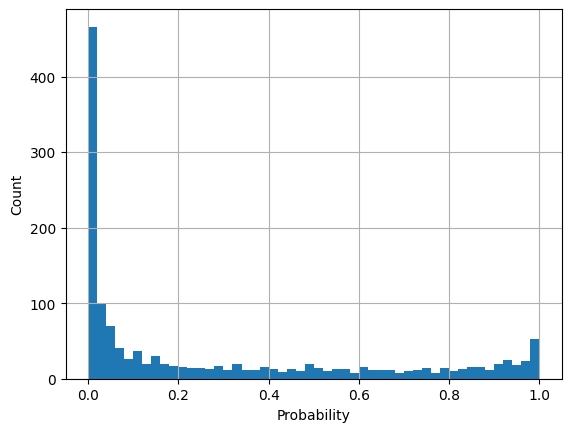

In [14]:
Y_lr_test = Y_proba_test[:,1]

plt.hist(Y_lr_test, bins=50)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [33]:
Y_hat_test = Y_lr_test > 0.35

In [34]:
accuracy = accuracy_score(Y_test, Y_hat_test)
precision = precision_score(Y_test, Y_hat_test)
recall = recall_score(Y_test, Y_hat_test)
f1 = f1_score(Y_test, Y_hat_test)

print(f'Accuracy : {accuracy}')
print(f'precision : {precision}')
print(f'recall : {recall}')
print(f'f1_score : {f1}')

Accuracy : 0.7636621717530163
precision : 0.542016806722689
recall : 0.6916890080428955
f1_score : 0.607773851590106


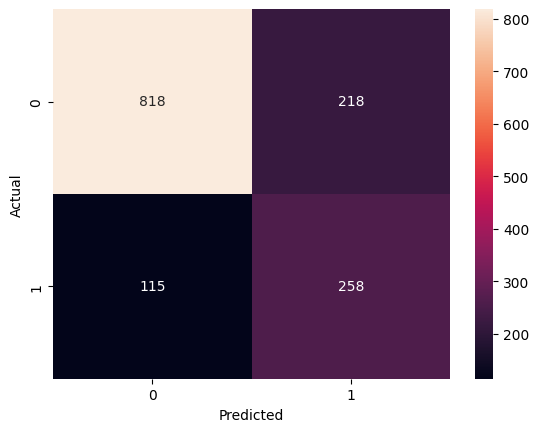

In [35]:
cm = confusion_matrix(Y_test, Y_hat_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()